[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fga-0/automating_data_augmentation/blob/main/stl_10.ipynb)

# Chargement des données STL10

 STL10 contient 5000 images d'entraînement et 8000 images de test.

In [1]:
path_to_data = "./STL10"

In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models


# Transformations basiques sans augmentation
transform_base = transforms.Compose([
    # transforms.Resize((32, 32)),  # Redimensionnement pour le modèle
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisation
])

# Chargement du dataset STL10
# Les images STL10 sont de dimension 96x96.
trainset = datasets.STL10(root=path_to_data, split='train', download=True, transform=transform_base)
testset = datasets.STL10(root=path_to_data, split='test', download=True, transform=transform_base)

# print(f"Dataset STL10 chargé: {len(trainset)} images d'entraînement, {len(testset)} images de test")


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_to_drive_data = "drive/MyDrive/SDD/data_augmentation/STL10"
# path_to_data = path_to_drive_data

# trainset = datasets.STL10(root=path_to_drive_data, split='train', download=False, transform=transform_base)
# testset = datasets.STL10(root=path_to_drive_data, split='test', download=False, transform=transform_base)

Mounted at /content/drive


In [14]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt
import numpy as np

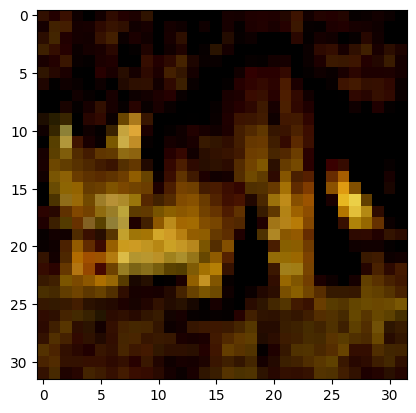

In [8]:
plt.imshow(np.transpose(trainset[4][0],(1,2,0)))

# Entraînement sur les données brutes

On va utiliser un modèle resnet18 afin de comparer les résultats d'une tâche de classification réalisée sur des données brutes puis augmentées.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
main_model = models.resnet18(pretrained=True)
num_features = main_model.fc.in_features
main_model.fc = torch.nn.Linear(num_features, 10) # adapting the last layer to the dataset (STL10) [10 classes].
main_model = main_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [ ]:
n_epochs = 100

In [12]:
import torch.optim as optim

# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(main_model.parameters(), lr=0.001)


def train_main_model(model, train_loader, criterion, optimizer, device, num_epochs=n_epochs):
    model.train()
    losses = []  # Stocker les pertes

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Afficher l'évolution de la loss
    plt.plot(range(1, num_epochs + 1), losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Loss pendant l'entraînement")
    plt.legend()
    plt.show()

    return model


In [13]:
def evaluate(model, test_loader, device):
    model.eval()  # Mode évaluation (désactive dropout, batchnorm)
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradient
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    error_rate = 1 - accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Taux d'erreur: {error_rate * 100:.2f}%")
    return accuracy, error_rate

Epoch [1/10], Loss: 1.5222
Epoch [2/10], Loss: 1.0988
Epoch [3/10], Loss: 0.9243
Epoch [4/10], Loss: 0.8192
Epoch [5/10], Loss: 0.5137
Epoch [6/10], Loss: 0.4048
Epoch [7/10], Loss: 0.6882
Epoch [8/10], Loss: 0.4739
Epoch [9/10], Loss: 0.5357
Epoch [10/10], Loss: 0.3229


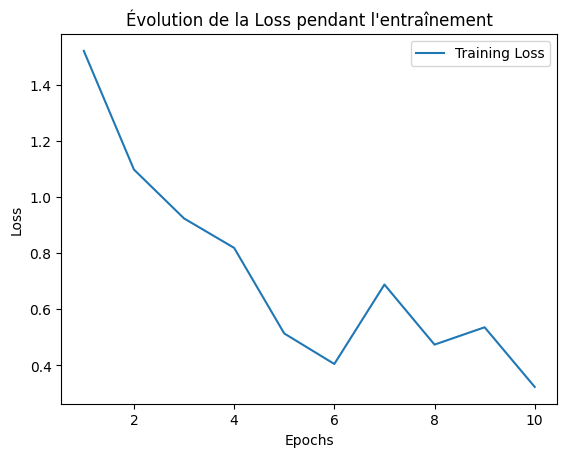

In [15]:
# Entraîner le modèle
trained_model = train_main_model(main_model, train_loader, criterion, optimizer, device, num_epochs=n_epochs)

In [16]:
# Évaluer sur le jeu de test
evaluate(trained_model, test_loader, device)

Accuracy: 64.18%
Taux d'erreur: 35.82%


(0.64175, 0.35824999999999996)

# CIFAR10 AutoAugment Policy 

AutoAugment a été implémenté pour trouver les meilleures politiques d'augmentation sur des datasets génériques et très répandus comme CIFAR10, IMAGENET ou SVHN.
Il est possible d'appliquer ces politiques d'augmentation sur d'autres datasets comme STL10. Se pose alors la question de la pertinence de ces politiques vu qu'il ne s'agit plus du dataset sur lequel ces politiques ont été obtenues. On peut néanmoins pressentir que les meilleures politiques obtenues pour CIFAR10 seront vraisemblablement de très bonnes politiques pour STL10 vu que ces deux dataset ont les mêmes natures de données à savoir des images représentant 10 catégories d'objets : 

airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. (frog à la place de monkey pour CIFAR)

In [ ]:
import torchvision
from torch.utils.data import ConcatDataset

In [ ]:
# Define transformation pipeline
AA_CIFAR_transform = transforms.Compose([
    # transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10),  # AutoAugment policy
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load STL-10 dataset
trainset_AA_CIFAR = datasets.STL10(root=path_to_data, split='train', download=True, transform=AA_CIFAR_transform)
trainset_raw_and_AA_CIFAR = ConcatDataset([trainset, trainset_AA_CIFAR])

testset_AA_CIFAR = testset
# NOTE : il ne me semble pas que le testset doive être augmenté... mais c'est à confirmer.
# testset_AA_CIFAR = datasets.STL10(root=path_to_data, split='test', download=True, transform=AA_CIFAR_transform)


# train_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
# test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)

# Create DataLoaders
train_loader_AA_CIFAR = DataLoader(trainset_raw_and_AA_CIFAR, batch_size=64, shuffle=True, num_workers=2)
test_loader_AA_CIFAR = DataLoader(testset_AA_CIFAR, batch_size=64, shuffle=False, num_workers=2)

# Check a sample batch
data_iter = iter(test_loader_AA_CIFAR)
images, labels = next(data_iter)
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")


In [ ]:
trained_model_AA_CIFAR = train_main_model(main_model, train_loader_AA_CIFAR, criterion, optimizer, device, num_epochs=n_epochs)

In [ ]:
evaluate(trained_model_AA_CIFAR, test_loader_AA_CIFAR, device)

# AutoAugment implementation on STL10

## Génération des Politiques d’Augmentation

On convertit la sortie du LSTM en transformations dynamiques.

Seules certaines transformations sont appliquées selon la politique générée.

In [17]:
images_size = trainset[0][0].shape[1] # if 32 : images are squares of 32x32

augmentations = [
    transforms.CenterCrop(size=16),
    transforms.RandomCrop(size=16),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), shear=15),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomInvert(p=0.5),
    transforms.RandomSolarize(-0.1, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
]

In [18]:
len(augmentations)

12

In [19]:
def plot_transformed_image(image, transformation) :
  transformed_image = transformation(image)
  plt.imshow(np.transpose(transformed_image, (1,2,0)))

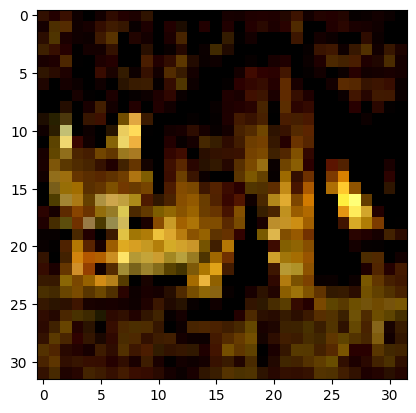

In [20]:
plot_transformed_image(trainset[4][0], augmentations[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.92156863].


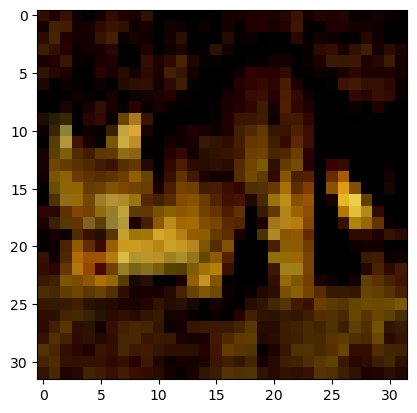

In [ ]:
plt.imshow(np.transpose(transforms.CenterCrop(size=32)(trainset[4][0]), (1,2,0)))

In [21]:
import random

def apply_augmentations(image,
                        policy,
                        replace : bool, # this argument is used to specify if the data should be replaced by the augmented data or enriched.
                        augmentations
                        ):
    image_aug = image

    for i, aug in enumerate(augmentations):
        if policy[i] > 0.5:  # Seuil pour activer une transformation
            image_aug = aug(image)
    if replace :
        return image_aug
    else :
        return image, image_aug


## Définition de l'agent LSTM

Ce LSTM prend en entrée un vecteur aléatoire et génère une politique d'augmentation.

Ce LSTM génère une politique d'augmentation sous forme de 5 nombres entre 0 et 1.

In [22]:
torch.cuda.is_available()

True

In [23]:
import torch.nn as nn
import torch

class AutoAugmentLSTM(nn.Module):
    def __init__(self, input_size=len(augmentations), hidden_size=128, num_layers=2, output_size=len(augmentations)):
        super(AutoAugmentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Dernière sortie de la séquence
        return torch.sigmoid(out)  # Convertir en probabilités entre 0 et 1

lstm = AutoAugmentLSTM().to(device)
# lstm = AutoAugmentLSTM().cuda()


## Modèle Proxy pour Tester les Augmentations

On entraîne un CNN léger (ResNet18) sur les données augmentées.

Ce modèle proxy nous permet de tester si une politique d’augmentation améliore l'entraînement.

In [24]:
from tqdm import tqdm
import torchvision.models as models

### Un proxy simplissime

Performances :

    RUN_0 :
        images 32x32
        batch_size=64
        20%|██        | 1/5 [00:51<03:27, 51.93s/it] Epoch [1/5], Loss: 1.7010
        num_worker=8

In [ ]:
output_size = 10  # there are 10 classes
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
proxy_model=SimpleCNN().to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Définition du modèle
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Première couche de convolution : entrée 3 canaux (RGB), sortie 32 filtres 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # MaxPooling 2x2 pour réduire la taille de l'image
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Couche entièrement connectée :
        # L'entrée doit correspondre à la taille après convolutions + pooling
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)  # 64 cartes de 8x8
        self.fc2 = nn.Linear(in_features=128, out_features=10)  # 10 classes
        # Placeholder pour fc1 (on ajustera dynamiquement)
        # self.fc1 = nn.Linear(1, 128)  # Placebo, on corrigera après
        # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution + ReLU + MaxPooling
        # print(f"Taille après convolutions et pooling: {x.shape}")

        x = x.view(x.size(0), -1)  # Mise à plat (Flatten)
        # print(f"Taille après flatten: {x.shape}")
        x = F.relu(self.fc1(x))  # Couche entièrement connectée + ReLU
        x = self.fc2(x)  # Dernière couche (sortie brute, non normalisée)

        return x

# Vérification du modèle
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
proxy_model=SimpleCNN().to(device)
print(proxy_model)  # Affichage de la structure du modèle


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
print(proxy_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


### Un proxy moins simple

In [25]:
import torchvision.models as models
proxy_model = models.resnet18(num_classes=10).to(device)

In [26]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(proxy_model.parameters(), lr=0.001)

def train_proxy_model(train_loader, model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [27]:
def evaluate_proxy_model(model, test_loader):
    model.eval()
    with torch.no_grad() :
      correct = 0
      total = 0
      total_loss = 0.0

      for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = total_loss /len(test_loader)
    return accuracy, avg_loss

## Boucle de Recherche pour Optimiser l’AutoAugment

On entraîne le LSTM en mettant à jour ses poids en fonction de l'amélioration des performances du modèle proxy.

Perfromances :

    RUN_0 :
        images 96x96
        batch_size=128
        60%|██████    | 3/5 [02:47<01:52, 56.39s/it]Epoch [3/5], Loss: 1.1865
        num_worker=4

    RUN_1 :
        images 32x32
        batch_size=128
        num_worker=4
        40%|████      | 2/5 [01:55<02:53, 57.88s/it]

    RUN_2 :
        images 32x32
        batch_size=64
        num_worker=4
        40%|████      | 2/5 [02:05<03:07, 62.54s/it]

    RUN_3 :
        images 32x32
        batch_size=64
        num_worker=8
        20%|██        | 1/5 [01:00<04:00, 60.17s/it] Epoch [1/5], Loss: 1.1175

    RUN_4 :
        images 32x32
        batch_size=64
        num_worker=8
        20%|██        | 1/5 [01:01<04:06, 61.54s/it] Epoch [1/5], Loss: 0.9135

In [31]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr=0.001)
loss_lstm = nn.MSELoss()  # Comparaison avec l'amélioration attendue

baseline_accuracy = 0.0

for iteration in range(100):  # Nombre d'itérations de recherche
    lstm_input = torch.randn(1, # batch size
                             len(augmentations), # sequence length
                             len(augmentations) #input size
                             ).to(device)  # Entrée aléatoire
    policy = lstm(lstm_input).detach().cpu().numpy()[0]  # Convertir en numpy

    # Appliquer la politique générée
    trainset_augmented = datasets.STL10(root=path_to_data, split='train', download=False,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Resize((32, 32)),
                                            transforms.Normalize((0.5,), (0.5,)),
                                            lambda img: apply_augmentations(img, policy, replace=True, augmentations=augmentations)])
                                        # transform = transforms.ToTensor()
                                        )

    train_loader_aug = DataLoader(trainset_augmented, batch_size=128, shuffle=True, num_workers=2)

    # Entraîner le modèle proxy avec la politique d'augmentation actuelle
    train_proxy_model(train_loader_aug, proxy_model, criterion, optimizer)

    # Évaluer la précision après augmentation
    accuracy_after, avg_loss = evaluate_proxy_model(proxy_model, test_loader)

    # Calculer la récompense et mettre à jour le LSTM
    reward = accuracy_after - baseline_accuracy
    loss = loss_lstm(torch.tensor([reward], dtype=torch.float32).to(device), lstm(lstm_input))
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()

    print(f"Iteration {iteration}, Reward: {reward:.4f}")


 20%|██        | 1/5 [00:09<00:36,  9.21s/it]

Epoch [1/5], Loss: 1.3907


 40%|████      | 2/5 [00:18<00:27,  9.25s/it]

Epoch [2/5], Loss: 1.3630


 60%|██████    | 3/5 [00:26<00:17,  8.57s/it]

Epoch [3/5], Loss: 1.3410


 80%|████████  | 4/5 [00:35<00:08,  8.84s/it]

Epoch [4/5], Loss: 1.2197


100%|██████████| 5/5 [00:43<00:00,  8.68s/it]

Epoch [5/5], Loss: 1.1211



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0, Reward: 0.4799


 20%|██        | 1/5 [00:08<00:33,  8.45s/it]

Epoch [1/5], Loss: 0.9679


 40%|████      | 2/5 [00:15<00:22,  7.42s/it]

Epoch [2/5], Loss: 0.9854


 60%|██████    | 3/5 [00:23<00:15,  7.99s/it]

Epoch [3/5], Loss: 0.8576


 80%|████████  | 4/5 [00:30<00:07,  7.66s/it]

Epoch [4/5], Loss: 0.9876


100%|██████████| 5/5 [00:39<00:00,  7.86s/it]

Epoch [5/5], Loss: 0.8759


Iteration 1, Reward: 0.4984


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

Epoch [1/5], Loss: 0.8681


 40%|████      | 2/5 [00:09<00:14,  4.76s/it]

Epoch [2/5], Loss: 0.7006


 60%|██████    | 3/5 [00:13<00:09,  4.66s/it]

Epoch [3/5], Loss: 0.7216


 80%|████████  | 4/5 [00:17<00:04,  4.40s/it]

Epoch [4/5], Loss: 0.5567


100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

Epoch [5/5], Loss: 0.4987


Iteration 2, Reward: 0.5188


 20%|██        | 1/5 [00:05<00:21,  5.41s/it]

Epoch [1/5], Loss: 0.3333


 40%|████      | 2/5 [00:09<00:13,  4.54s/it]

Epoch [2/5], Loss: 0.2599


 60%|██████    | 3/5 [00:13<00:08,  4.27s/it]

Epoch [3/5], Loss: 0.3318


 80%|████████  | 4/5 [00:19<00:04,  4.91s/it]

Epoch [4/5], Loss: 0.4921


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]

Epoch [5/5], Loss: 0.3790


Iteration 3, Reward: 0.5038


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Epoch [1/5], Loss: 0.2827


 40%|████      | 2/5 [00:09<00:14,  4.69s/it]

Epoch [2/5], Loss: 0.2783


 60%|██████    | 3/5 [00:13<00:09,  4.60s/it]

Epoch [3/5], Loss: 0.1542


 80%|████████  | 4/5 [00:17<00:04,  4.35s/it]

Epoch [4/5], Loss: 0.2265


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]

Epoch [5/5], Loss: 0.3174


Iteration 4, Reward: 0.4706


 20%|██        | 1/5 [00:07<00:30,  7.70s/it]

Epoch [1/5], Loss: 0.3056


 40%|████      | 2/5 [00:13<00:19,  6.63s/it]

Epoch [2/5], Loss: 0.0977


 60%|██████    | 3/5 [00:21<00:14,  7.17s/it]

Epoch [3/5], Loss: 0.0730


 80%|████████  | 4/5 [00:27<00:06,  6.57s/it]

Epoch [4/5], Loss: 0.1503


100%|██████████| 5/5 [00:34<00:00,  6.93s/it]

Epoch [5/5], Loss: 0.0552


Iteration 5, Reward: 0.5215


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

Epoch [1/5], Loss: 0.1328


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

Epoch [2/5], Loss: 0.2482


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

Epoch [3/5], Loss: 0.1520


 80%|████████  | 4/5 [00:15<00:04,  4.10s/it]

Epoch [4/5], Loss: 0.2347


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]

Epoch [5/5], Loss: 0.1886


Iteration 6, Reward: 0.5040


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

Epoch [1/5], Loss: 0.1046


 40%|████      | 2/5 [00:09<00:13,  4.63s/it]

Epoch [2/5], Loss: 0.2214


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]

Epoch [3/5], Loss: 0.2649


 80%|████████  | 4/5 [00:16<00:04,  4.02s/it]

Epoch [4/5], Loss: 0.1732


100%|██████████| 5/5 [00:20<00:00,  4.16s/it]

Epoch [5/5], Loss: 0.0692


Iteration 7, Reward: 0.5034


 20%|██        | 1/5 [00:05<00:20,  5.02s/it]

Epoch [1/5], Loss: 0.2913


 40%|████      | 2/5 [00:08<00:11,  3.91s/it]

Epoch [2/5], Loss: 0.1731


 60%|██████    | 3/5 [00:11<00:07,  3.56s/it]

Epoch [3/5], Loss: 0.0412


 80%|████████  | 4/5 [00:14<00:03,  3.45s/it]

Epoch [4/5], Loss: 0.0113


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]

Epoch [5/5], Loss: 0.0388


Iteration 8, Reward: 0.5210


 20%|██        | 1/5 [00:05<00:22,  5.58s/it]

Epoch [1/5], Loss: 0.7422


 40%|████      | 2/5 [00:11<00:17,  5.86s/it]

Epoch [2/5], Loss: 0.4509


 60%|██████    | 3/5 [00:18<00:12,  6.20s/it]

Epoch [3/5], Loss: 0.2626


 80%|████████  | 4/5 [00:23<00:05,  5.89s/it]

Epoch [4/5], Loss: 0.2233


100%|██████████| 5/5 [00:30<00:00,  6.15s/it]

Epoch [5/5], Loss: 0.2127


Iteration 9, Reward: 0.5145


 20%|██        | 1/5 [00:08<00:35,  8.80s/it]

Epoch [1/5], Loss: 0.3391


 40%|████      | 2/5 [00:19<00:29,  9.81s/it]

Epoch [2/5], Loss: 0.2679


 60%|██████    | 3/5 [00:29<00:20, 10.13s/it]

Epoch [3/5], Loss: 0.2546


 80%|████████  | 4/5 [00:38<00:09,  9.67s/it]

Epoch [4/5], Loss: 0.0753


100%|██████████| 5/5 [00:49<00:00,  9.83s/it]

Epoch [5/5], Loss: 0.0837


Iteration 10, Reward: 0.5346


 20%|██        | 1/5 [00:13<00:52, 13.07s/it]

Epoch [1/5], Loss: 0.1379


 40%|████      | 2/5 [00:25<00:38, 12.98s/it]

Epoch [2/5], Loss: 0.1200


 60%|██████    | 3/5 [00:39<00:26, 13.09s/it]

Epoch [3/5], Loss: 0.1810


 80%|████████  | 4/5 [00:51<00:12, 12.76s/it]

Epoch [4/5], Loss: 0.0455


100%|██████████| 5/5 [01:03<00:00, 12.66s/it]

Epoch [5/5], Loss: 0.0697


Iteration 11, Reward: 0.5172


 20%|██        | 1/5 [00:13<00:55, 13.83s/it]

Epoch [1/5], Loss: 0.4432


 40%|████      | 2/5 [00:27<00:41, 13.86s/it]

Epoch [2/5], Loss: 0.2611


 60%|██████    | 3/5 [00:41<00:27, 13.93s/it]

Epoch [3/5], Loss: 0.2269


 80%|████████  | 4/5 [00:55<00:13, 13.90s/it]

Epoch [4/5], Loss: 0.2684


100%|██████████| 5/5 [01:09<00:00, 13.92s/it]

Epoch [5/5], Loss: 0.1353


Iteration 12, Reward: 0.5195


 20%|██        | 1/5 [00:13<00:54, 13.73s/it]

Epoch [1/5], Loss: 0.1816


 40%|████      | 2/5 [00:27<00:41, 13.88s/it]

Epoch [2/5], Loss: 0.1606


 60%|██████    | 3/5 [00:41<00:27, 13.90s/it]

Epoch [3/5], Loss: 0.2040


 80%|████████  | 4/5 [00:55<00:13, 13.83s/it]

Epoch [4/5], Loss: 0.2593


100%|██████████| 5/5 [01:09<00:00, 13.80s/it]

Epoch [5/5], Loss: 0.1885


Iteration 13, Reward: 0.5282


 20%|██        | 1/5 [00:13<00:53, 13.30s/it]

Epoch [1/5], Loss: 0.2093


 40%|████      | 2/5 [00:26<00:40, 13.45s/it]

Epoch [2/5], Loss: 0.1587


 60%|██████    | 3/5 [00:40<00:27, 13.56s/it]

Epoch [3/5], Loss: 0.0833


 80%|████████  | 4/5 [00:54<00:13, 13.55s/it]

Epoch [4/5], Loss: 0.1304


100%|██████████| 5/5 [01:07<00:00, 13.55s/it]

Epoch [5/5], Loss: 0.2091


Iteration 14, Reward: 0.5026


 20%|██        | 1/5 [00:13<00:55, 13.86s/it]

Epoch [1/5], Loss: 0.2883


 40%|████      | 2/5 [00:27<00:41, 13.79s/it]

Epoch [2/5], Loss: 0.0917


 60%|██████    | 3/5 [00:41<00:27, 13.83s/it]

Epoch [3/5], Loss: 0.0441


 80%|████████  | 4/5 [00:55<00:13, 13.95s/it]

Epoch [4/5], Loss: 0.0351


100%|██████████| 5/5 [01:09<00:00, 13.93s/it]

Epoch [5/5], Loss: 0.0880


Iteration 15, Reward: 0.5141


 20%|██        | 1/5 [00:13<00:54, 13.73s/it]

Epoch [1/5], Loss: 0.1435


 40%|████      | 2/5 [00:27<00:41, 13.76s/it]

Epoch [2/5], Loss: 0.0742


 60%|██████    | 3/5 [00:41<00:27, 13.80s/it]

Epoch [3/5], Loss: 0.1012


 80%|████████  | 4/5 [00:55<00:13, 13.83s/it]

Epoch [4/5], Loss: 0.0925


100%|██████████| 5/5 [01:09<00:00, 13.81s/it]

Epoch [5/5], Loss: 0.0752


Iteration 16, Reward: 0.5110


 20%|██        | 1/5 [00:13<00:54, 13.62s/it]

Epoch [1/5], Loss: 0.2394


 40%|████      | 2/5 [00:27<00:40, 13.65s/it]

Epoch [2/5], Loss: 0.1625


 60%|██████    | 3/5 [00:41<00:27, 13.70s/it]

Epoch [3/5], Loss: 0.1513


 80%|████████  | 4/5 [00:54<00:13, 13.44s/it]

Epoch [4/5], Loss: 0.2188


100%|██████████| 5/5 [01:07<00:00, 13.49s/it]

Epoch [5/5], Loss: 0.0613


Iteration 17, Reward: 0.5151


 20%|██        | 1/5 [00:13<00:53, 13.43s/it]

Epoch [1/5], Loss: 0.0871


 40%|████      | 2/5 [00:27<00:40, 13.55s/it]

Epoch [2/5], Loss: 0.0635


 60%|██████    | 3/5 [00:40<00:27, 13.68s/it]

Epoch [3/5], Loss: 0.0300


 80%|████████  | 4/5 [00:54<00:13, 13.70s/it]

Epoch [4/5], Loss: 0.0302


100%|██████████| 5/5 [01:08<00:00, 13.70s/it]

Epoch [5/5], Loss: 0.0188


Iteration 18, Reward: 0.5135


  0%|          | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Application de la Meilleure Politique Trouvée

Une fois la meilleure politique identifiée, on applique la meilleure politique trouvée et on entraîne un modèle final performant.

In [37]:
def find_best_policy(lstm):
    """
    Extrait la meilleure politique d'augmentation trouvée après l'entraînement du LSTM.

    Args:
        lstm (torch.nn.Module): Le réseau LSTM entraîné.

    Returns:
        best_policy (list): Liste des transformations correspondant à la meilleure politique.
    """
    lstm.eval()

    with torch.no_grad():
        # Initialisation du LSTM (ex: état caché nul)
        hidden = None
        input_tensor = torch.zeros(1, 1, len(augmentations)).to(next(lstm.parameters()).device)  # Format d'entrée attendu

        best_policy = []

        # Générer la séquence d'augmentations
        for _ in range(5):  # On suppose une séquence de 5 transformations max
            output = lstm(input_tensor)
            print(output)

            # Convertir la sortie en un index de transformation
            transformation_idx = torch.argmax(output, dim=-1).item()

            # Ajouter la transformation correspondante
            best_policy.append(augmentations[transformation_idx])

            # Mettre à jour l'entrée pour le LSTM
            input_tensor = output.unsqueeze(0)

    return best_policy


In [38]:
best_policy = find_best_policy(lstm)  # Fonction qui extrait la meilleure politique


tensor([[0.4980, 0.5082, 0.5121, 0.4934, 0.5077, 0.4880, 0.4896, 0.5116, 0.4969,
         0.4899, 0.5181, 0.5107]], device='cuda:0')
tensor([[0.4990, 0.5091, 0.5130, 0.4933, 0.5084, 0.4877, 0.4893, 0.5110, 0.4968,
         0.4892, 0.5186, 0.5107]], device='cuda:0')
tensor([[0.4990, 0.5091, 0.5130, 0.4933, 0.5084, 0.4877, 0.4893, 0.5110, 0.4968,
         0.4892, 0.5186, 0.5107]], device='cuda:0')
tensor([[0.4990, 0.5091, 0.5130, 0.4933, 0.5084, 0.4877, 0.4893, 0.5110, 0.4968,
         0.4892, 0.5186, 0.5107]], device='cuda:0')
tensor([[0.4990, 0.5091, 0.5130, 0.4933, 0.5084, 0.4877, 0.4893, 0.5110, 0.4968,
         0.4892, 0.5186, 0.5107]], device='cuda:0')


In [36]:
best_policy

[RandomAutocontrast(p=0.5),
 RandomAutocontrast(p=0.5),
 RandomAutocontrast(p=0.5),
 RandomAutocontrast(p=0.5),
 RandomAutocontrast(p=0.5)]

In [ ]:
from torch.utils.data import ConcatDataset
import torchvision.models as models

In [ ]:
best_policy = find_best_policy(lstm)  # Fonction qui extrait la meilleure politique
print(f"Meilleure politique trouvée : {best_policy}")

# Appliquer aux données finales
transform_final = lambda img: apply_augmentations(img, best_policy, replace=True, augmentations=augmentations)
trainset_aug = datasets.STL10(root="./STL10", split='train', download=True, transform=transform_final)
trainset_final = concat_dataset = ConcatDataset([trainset, trainset_aug])
train_loader_final = DataLoader(trainset_final, batch_size=128, shuffle=True, num_workers=2)

# Entraîner le modèle final (ex: WideResNet)
# final_model = WideResNet(depth=28, width=10, num_classes=10).to(device)
final_model = models.resnet18(pretrained=True)
num_features = final_model.fc.in_features
final_model.fc = torch.nn.Linear(num_features, 10) # adapting the last layer to the dataset (STL10) [10 classes].
final_model = final_model.to(device)

optimizer_final = optim.SGD(final_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_main_model(train_loader_final, final_model, criterion, optimizer_final)

Meilleure politique trouvée : [RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0), RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0), RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0), RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0), RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)]
Files already downloaded and verified


NameError: name 'WideResNet' is not defined

## CNN

In [ ]:
# from simple_cnn import SimpleCNN
# import torch.nn as nn
# import torch.optim as optim

# # Initialisation du modèle
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN().to(device)

# # Fonction de perte et optimiseur
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Entraînement du modèle sur les données brutes
# for epoch in range(10):  # Petit entraînement pour test
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

# print("✅ Modèle entraîné sur données brutes !")
